# IMPORTS

In [26]:
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary

from metrics import mean_absolute_error, peak_signal_to_noise_ratio, structural_similarity_index
from utils import save_image, sample_images

# CONSTANTS

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = Path("./MVA-Dose-Prediction/")
Tensor = torch.cuda.FloatTensor if DEVICE == "cuda" else torch.FloatTensor

# DATA

In [7]:
if not DATA_DIR.is_dir():
    !git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

## Visualize data images

In [8]:
def plot_sample(sample_folder_path):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'ct.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("CT")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'possible_dose_mask.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Possible dose mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'structure_masks.npy').sum(axis=0), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Structure masks")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'dose.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Dose")
    plt.axis('off')
    plt.show()

<Figure size 1080x720 with 0 Axes>

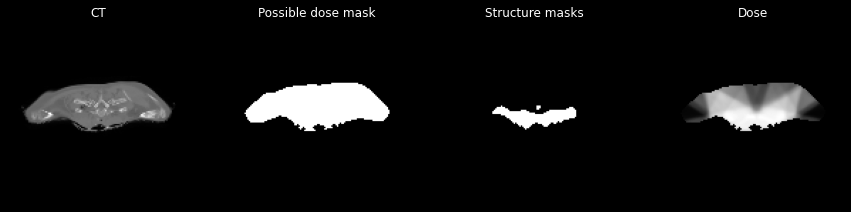

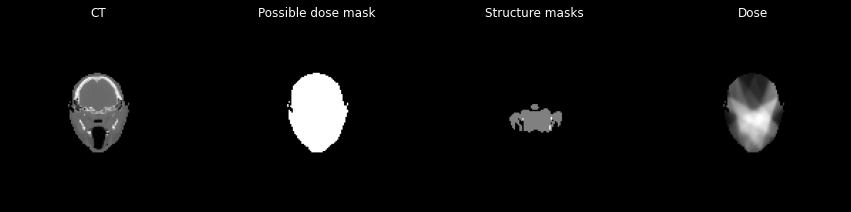

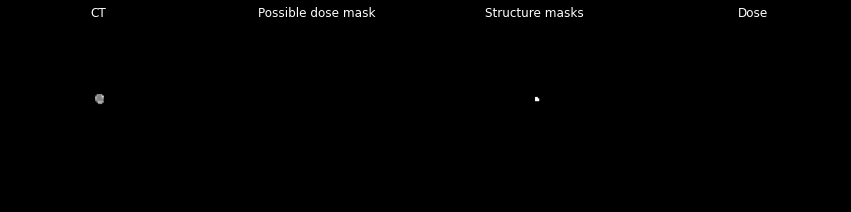

In [11]:
all_train_samples = list((DATA_DIR/"train").iterdir())
n_train_samples = len(all_train_samples)

plt.figure(figsize=(15, 10))

for i in np.random.choice(np.arange(0, n_train_samples), 3):
  path = all_train_samples[i]
  plot_sample(path)

## Dataset

In [12]:
class DoseDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train"):

        self.files = sorted((root/mode).iterdir())
        self.mode = mode

    def __getitem__(self, index):
        img = np.vstack(
            (
                np.load(self.files[index]/"ct.npy")[np.newaxis, :, :],
                np.load(self.files[index]/"structure_masks.npy")
            )
        )
        return {
            "ct": np.load(self.files[index]/"ct.npy"),
            "structure_masks": np.load(self.files[index]/"structure_masks.npy"),
            "img": img, 
            "possible_dose_mask": np.load(self.files[index]/"possible_dose_mask.npy"),
            "dose": np.load(self.files[index]/"dose.npy") if self.mode != "test" else None,
        }

    def __len__(self):
        return len(self.files)

# MODEL

## Architecture:
- Generator :
  - UNet
- Discrimintor :
  - 3 layer-CNN with a 2-layer Dense classification head

## Generator

Convolutional UNet with 5 downscale layers and 5 upscale layers

In [13]:
class Down(nn.Module):
    def __init__(self, in_size, out_size):
        super(Down, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)


class Up(nn.Module):
    def __init__(self, in_size, out_size):
        super(Up, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4,
                               stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU()
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=11, out_channels=1):
        super(Generator, self).__init__()

        self.down1 = Down(in_channels, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 256)

        self.up1 = Up(256, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 32)

        self.head = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)
        
        u4 = torch.cat((u4, d1), dim=1)
        out = self.head(u4)

        return out

In [18]:
summary(Generator().to(DEVICE), input_size=(11, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           3,200
    InstanceNorm2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
              Down-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
    InstanceNorm2d-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
              Down-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
   InstanceNorm2d-10          [-1, 128, 16, 16]               0
             ReLU-11          [-1, 128, 16, 16]               0
             Down-12          [-1, 128, 16, 16]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
   InstanceNorm2d-14            [-1, 25

## Discriminator

In [20]:
class Discriminator(nn.Module):
    def __init__(self, dropout=0.1):
        super(Discriminator, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 128, 5, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(128, 256, 3, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(256, 256, 3, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            torch.nn.Dropout(dropout),
            torch.nn.LazyLinear(100),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.model(x)

In [21]:
summary(Discriminator().to(DEVICE), input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 62, 62]           3,328
         MaxPool2d-2          [-1, 128, 31, 31]               0
       BatchNorm2d-3          [-1, 128, 31, 31]             256
           Dropout-4          [-1, 128, 31, 31]               0
              ReLU-5          [-1, 128, 31, 31]               0
            Conv2d-6          [-1, 256, 15, 15]         295,168
         MaxPool2d-7            [-1, 256, 7, 7]               0
       BatchNorm2d-8            [-1, 256, 7, 7]             512
           Dropout-9            [-1, 256, 7, 7]               0
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
          Dropout-14            [-1, 25

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
LR = 1e-3
N_EPOCHS = 5
BATCH_SIZE = 128

# Output folder
if not os.path.exists("./images/generator"):
    os.makedirs("./images/generator")

# Loss function
l1_criterion = torch.nn.L1Loss()
cross_entropy_loss = torch.nn.BCEWithLogitsLoss()

# Initialize the generator
generator = Generator()
discriminator = Discriminator()

train_dataset = DoseDataset(root=DATA_DIR, mode="train")
test_dataset = DoseDataset(root=DATA_DIR, mode="test")
val_dataset = DoseDataset(root=DATA_DIR, mode="validation")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


if DEVICE == "cuda":
    generator = generator.cuda()
    discriminator.cuda()
    l1_criterion.cuda()
    cross_entropy_loss.cuda()

# Optimizer
optimizerG = torch.optim.Adam(
    generator.parameters(),
    lr=LR,
)
optimizerD = torch.optim.Adam(
    discriminator.parameters(),
    lr=LR,
)

prev_time = time.time()

for epoch in range(N_EPOCHS):
    for i, batch in enumerate(train_dataloader):

        img = batch["img"].type(Tensor)
        real_dose = batch["dose"].type(Tensor)
        
        generated_dose = generator(img)
        discriminator_on_real_dose = discriminator(real_dose[:, None, :, :])
        discriminator_on_generated_dose = discriminator(generated_dose)
        
        
        # Train Discriminator
        optimizerD.zero_grad()
        pos_samples_loss = cross_entropy_loss(
            input=discriminator_on_real_dose, target=torch.ones(size=(len(real_dose), 1), device=DEVICE)
        )
        neg_samples_loss = cross_entropy_loss(
            input=discriminator_on_generated_dose, target=torch.zeros(size=(len(real_dose), 1), device=DEVICE)
        )
        discriminator_loss = pos_samples_loss + neg_samples_loss
        discriminator_loss.backward()
        optimizerD.step()
        
        
        # Train Generator
        optimizerG.zero_grad()
        generated_dose = generator(img)
        discriminator_on_generated_dose = discriminator(generated_dose)
        generator_l1_loss = l1_criterion(
            input=generated_dose,
            target=real_dose
        )
        generator_adversarial_loss = cross_entropy_loss(
            input=discriminator_on_generated_dose,
            target=torch.ones(size=(len(real_dose), 1), device=DEVICE)
        )
        
        generator_loss = generator_l1_loss + generator_adversarial_loss
        generator_loss.backward()
        optimizerG.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(train_dataloader) + i
        batches_left = N_EPOCHS * len(train_dataloader) - batches_done
        time_left = datetime.timedelta(
            seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [DLoss: %f] [GLoss: %f] ETA: %s"
            % (
                epoch + 1,
                N_EPOCHS,
                i,
                len(train_dataloader),
                discriminator_loss.item(),
                generator_loss.item(),
                time_left,
            )
        )

    # Save images at the end of each epoch
    sample_images(epoch, generator)

Using cuda device: True
[Epoch 1/5] [Batch 31/61] [DLoss: 0.928105] [GLoss: 4.334406] ETA: 0:12:59.762767

# EVALUATE

In [ ]:
def evaluate_generator(generator):
    """Evaluate a generator.

    Args:
        generator: (GeneratorUNet) neural network generating T2-w images

    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    with torch.no_grad():

        for i, batch in enumerate(train_dataloader):

            # Inputs T1-w and T2-w
            real_img = batch["img"].type(Tensor)
            real_dose = batch["dose"].type(Tensor)
            real_possible_dose_mask = batch["possible_dose_mask"].type(Tensor)
            fake_dose = generator(real_img)
            fake_dose = (real_possible_dose_mask*fake_dose[:, 0, :,:])

            mae = mean_absolute_error(real_dose, fake_dose).item()
            psnr = peak_signal_to_noise_ratio(real_dose, fake_dose).item()
            ssim = structural_similarity_index(real_dose, fake_dose).item()

            res_train.append([mae, psnr, ssim])

        for i, batch in enumerate(val_dataloader):

            # Inputs T1-w and T2-w
            real_img = batch["img"].type(Tensor)
            real_dose = batch["dose"].type(Tensor)
            real_possible_dose_mask = batch["possible_dose_mask"].type(Tensor)
            fake_dose = generator(real_img)
            fake_dose = (real_possible_dose_mask*fake_dose[:, 0, :,:])

            mae = mean_absolute_error(real_dose, fake_dose).item()
            psnr = peak_signal_to_noise_ratio(real_dose, fake_dose).item()
            ssim = structural_similarity_index(real_dose, fake_dose).item()

            res_test.append([mae, psnr, ssim])

        df = pd.DataFrame([
            pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
            pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
        ], index=['Training set', 'Test set']).T
    return df

In [ ]:
df = evaluate_generator(generator)

In [ ]:
df

,Training set,Test set
MAE,2.890694,2.868186
PSNR,-21.373302,-21.123186
SSIM,0.001299,0.001497
